In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf

warnings.simplefilter(action='ignore', category=FutureWarning)

2022-11-11 01:26:55.192639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 01:26:55.291390: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-11 01:26:55.294852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stefanie/.pyenv/versions/3.10.6/envs/eyes-cnn/lib/python3.10/site-packages/cv2/../../lib64

# CNN Model for Image Classification
The goal of this project is to build a model to scan the image of an eye of a patient and find out whether their sex is male or female. The training dataset consists of 9220 images.

## Data Preprocessing

In [2]:
# Function for reading in images

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return filenames, images

In [3]:
# Loading the data

data_df = pd.DataFrame(load_images_from_folder('../data/train-data/')).T
data_df.rename(columns={0: 'filename', 1: 'data'}, inplace=True)
data_df

,filename,data
0,Image_9220.jpg,"[[[221, 222, 232], [221, 222, 232], [223, 224,..."
1,Image_4037.jpg,"[[[139, 162, 238], [146, 169, 245], [146, 169,..."
2,Image_1242.jpg,"[[[46, 64, 95], [54, 73, 106], [54, 73, 108], ..."
3,Image_252.jpg,"[[[125, 144, 182], [125, 144, 182], [125, 144,..."
4,Image_5357.jpg,"[[[128, 149, 200], [130, 151, 202], [128, 146,..."
...,...,...
9215,Image_4189.jpg,"[[[115, 138, 184], [117, 140, 186], [116, 137,..."
9216,Image_8665.jpg,"[[[183, 203, 238], [184, 204, 239], [181, 202,..."
9217,Image_2238.jpg,"[[[171, 171, 171], [171, 171, 171], [171, 171,..."
9218,Image_5071.jpg,"[[[122, 155, 224], [119, 152, 221], [122, 153,..."


In [4]:
# Loading the train_targets dataset

targets = pd.read_csv('../data/targets_train.csv')
targets.head()

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


Note the different order of the target dataset and how the data was read in by cv2:

In [5]:
# Printing the first five elements to make sure we've got the same order

print(f'First 5 filenames from the target dataset: {list(targets.iloc[:5,0])}')
print(f'First 5 filenames after cv2.iread: {list(data_df.iloc[:5,0])}')

First 5 filenames from the target dataset: ['Image_1.jpg', 'Image_2.jpg', 'Image_3.jpg', 'Image_4.jpg', 'Image_5.jpg']
First 5 filenames after cv2.iread: ['Image_9220.jpg', 'Image_4037.jpg', 'Image_1242.jpg', 'Image_252.jpg', 'Image_5357.jpg']


In order to make up y the correct way, we have to match the correct data-target pairs together.

In [6]:
data_df = pd.merge(data_df, targets, on='filename')
data_df

,filename,data,label
0,Image_9220.jpg,"[[[221, 222, 232], [221, 222, 232], [223, 224,...",female
1,Image_4037.jpg,"[[[139, 162, 238], [146, 169, 245], [146, 169,...",male
2,Image_1242.jpg,"[[[46, 64, 95], [54, 73, 106], [54, 73, 108], ...",female
3,Image_252.jpg,"[[[125, 144, 182], [125, 144, 182], [125, 144,...",female
4,Image_5357.jpg,"[[[128, 149, 200], [130, 151, 202], [128, 146,...",male
...,...,...,...
9215,Image_4189.jpg,"[[[115, 138, 184], [117, 140, 186], [116, 137,...",female
9216,Image_8665.jpg,"[[[183, 203, 238], [184, 204, 239], [181, 202,...",female
9217,Image_2238.jpg,"[[[171, 171, 171], [171, 171, 171], [171, 171,...",female
9218,Image_5071.jpg,"[[[122, 155, 224], [119, 152, 221], [122, 153,...",male


The data we read in is the whole training set. So we don't need to make a train test split.

In [7]:
# Defining our X and y

data = list(data_df['data'])
y = data_df['label']

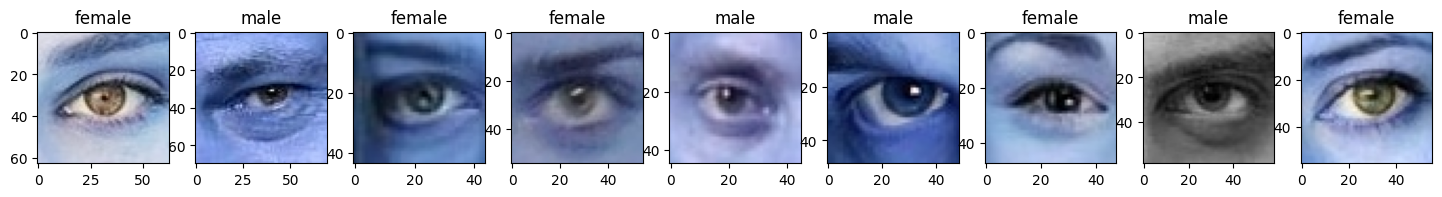

In [8]:
# Visualising images

fig, axs = plt.subplots(1, 9, figsize=(18,3))

for i in range (9):
    img = data[i][:,:]
    axs[i].imshow(img)
    axs[i].set_title(f'{y[i]}')

In [9]:
# Checking if all the images have the same dimension
path = '../data/train-data/'

same_dimension = True

for i in range (9220):
    img_name = f'Image_{i+1}.jpg'
    full_path = path + img_name
    img = cv2.imread(full_path)
    if img.shape != (63, 63, 3):
        same_dimension = False

same_dimension

False

The images' dimensions differ. Thus, they shouldn't be fed into the same model. Let's find out about how different shapes spread among the data.

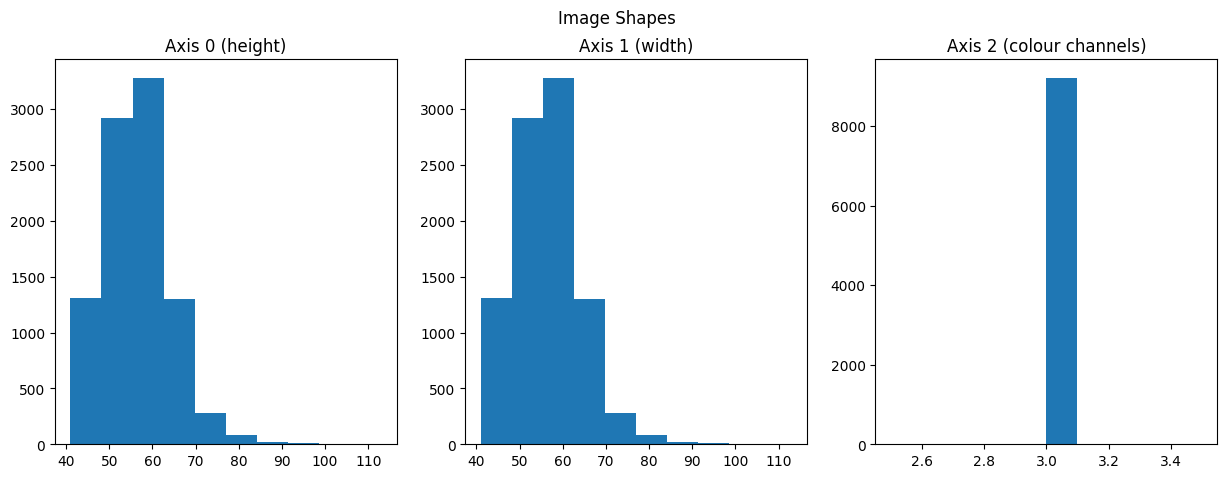

In [10]:
# Plotting the spread of image sizes

path = '../data/train-data/'
dim_axis0 = []
dim_axis1 = []
dim_axis2 = []

for i in range (9220):
    img_name = f'Image_{i+1}.jpg'
    full_path = path + img_name
    img = cv2.imread(full_path)
    dim_axis0.append(img.shape[0])
    dim_axis1.append(img.shape[1])
    dim_axis2.append(img.shape[2])

fig, axs = plt.subplots(1, 3, figsize=(15,5))
plt.suptitle('Image Shapes')

axs[0].hist(dim_axis0)
axs[0].set_title('Axis 0 (height)')

axs[1].hist(dim_axis1)
axs[1].set_title('Axis 1 (width)')

axs[2].hist(dim_axis2)
axs[2].set_title('Axis 2 (colour channels)');

We should resize all the images to the smallest dimensions in the dataset (which is (41,41,3)).

In [11]:
# Downscaling all the images to dimension (41, 41, 3) 

def downscaling(data):
    data_resized = []

    for image in data:
        image_resized = cv2.resize(image, (41, 41))
        data_resized.append(image_resized)

    return np.array(data_resized)

data_resized = downscaling(data)
data_resized.shape

(9220, 41, 41, 3)

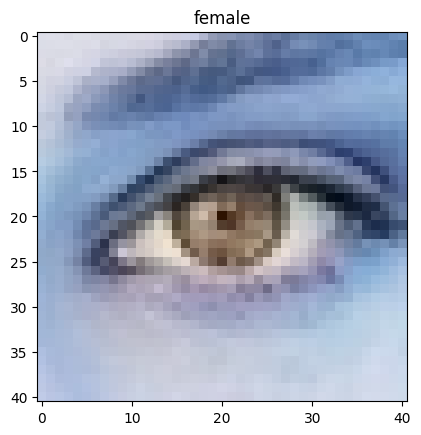

In [12]:
# Let's have a look at one of the downscaled images

plt.imshow(data_resized[0])
plt.title(f'{y[0]}');

Since the colourful images don't train very well (some have unnatural colours anyways), we're going to greyscale all of the images.

In [13]:
# Function for converting all the images into greyscale images

def greyscaling(data):
    data_resized_and_greyscaled = []
    
    for image in data:
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data_resized_and_greyscaled.append(gray_img)
        
    return np.array(data_resized_and_greyscaled).reshape(-1, 41, 41, 1)

data_resized_and_greyscaled = greyscaling(data_resized)

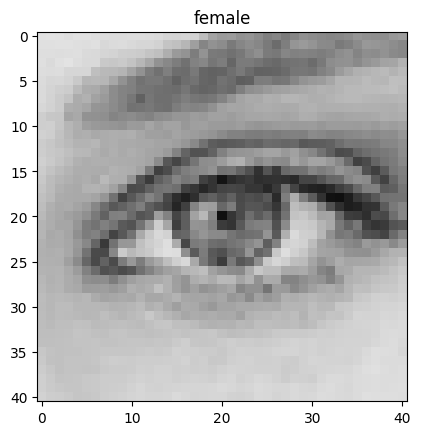

In [14]:
# Let's have a look at one of the greyscaled images

# for for plt.imshow(), it's necessary to scale image back to RGB, since it expects a 3d array
plt.imshow(cv2.cvtColor(data_resized_and_greyscaled[0],cv2.COLOR_GRAY2RGB))
plt.title(f'{y[0]}');

Now, we will normalise the intensities from the images, so they become more comparable.

In [15]:
# Normalising image data

def normalise(data):
    data = data / 255
    return data

data_resized_and_greyscaled = normalise(data_resized_and_greyscaled)

(We can't plot this anymore. It would be a white plane.)

We will now convert the target column into digits.

In [16]:
# Mapping the target values to 0 and 1

y_binary = y.map({'female': 0, 'male': 1})
y_binary

0       0
1       1
2       0
3       0
4       1
       ..
9215    0
9216    0
9217    0
9218    1
9219    0
Name: label, Length: 9220, dtype: int64

In [17]:
# Checking if target is balanced
y_binary.value_counts()

1    5058
0    4162
Name: label, dtype: int64

The two classes in the target are almost balanced. No rebalancing necessary.

## Build CNN Model Architecture

In [18]:
INPUT_SHAPE_COLOURFUL = (41, 41, 3)
INPUT_SHAPE_GREYSCALED = (41, 41, 1)

opt = tf.keras.optimizers.Adam(learning_rate=1, beta_1=0.9, beta_2=0.99)


model = tf.keras.models.Sequential()

# convolutional layers
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid', input_shape=INPUT_SHAPE_GREYSCALED))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# flatten layer
model.add(tf.keras.layers.Flatten())

# dense layers with some dropout
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #sigmoid tanh relu


# compile model
model.compile(#optimizer=opt, 
              optimizer='adam',
              #optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics='accuracy')

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 39, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0

2022-11-11 01:27:10.855028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stefanie/.pyenv/versions/3.10.6/envs/eyes-cnn/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-11 01:27:10.855049: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-11 01:27:10.855066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Future): /proc/driver/nvidia/version does not exist
2022-11-11 01:27:10.855247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropri

## Training the model

In [19]:
EPOCHS = 100

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(data_resized_and_greyscaled, y_binary,
                    batch_size=16,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
519/519 [==============================] - 3s 4ms/step - loss: 0.6902 - accuracy: 0.5453 - val_loss: 0.6874 - val_accuracy: 0.5499
Epoch 2/100
519/519 [==============================] - 2s 4ms/step - loss: 0.5524 - accuracy: 0.7110 - val_loss: 0.4065 - val_accuracy: 0.8221
Epoch 3/100
519/519 [==============================] - 2s 4ms/step - loss: 0.3877 - accuracy: 0.8407 - val_loss: 0.3689 - val_accuracy: 0.8319
Epoch 4/100
519/519 [==============================] - 2s 4ms/step - loss: 0.3220 - accuracy: 0.8709 - val_loss: 0.2952 - val_accuracy: 0.8785
Epoch 5/100
519/519 [==============================] - 2s 4ms/step - loss: 0.2930 - accuracy: 0.8802 - val_loss: 0.3077 - val_accuracy: 0.8807
Epoch 6/100
519/519 [==============================] - 2s 5ms/step - loss: 0.2744 - accuracy: 0.8926 - val_loss: 0.2581 - val_accuracy: 0.8894
Epoch 7/100
519/519 [==============================] - 2s 5ms/step - loss: 0.2490 - accuracy: 0.9041 - val_loss: 0.2376 - val_accuracy: 0.9176

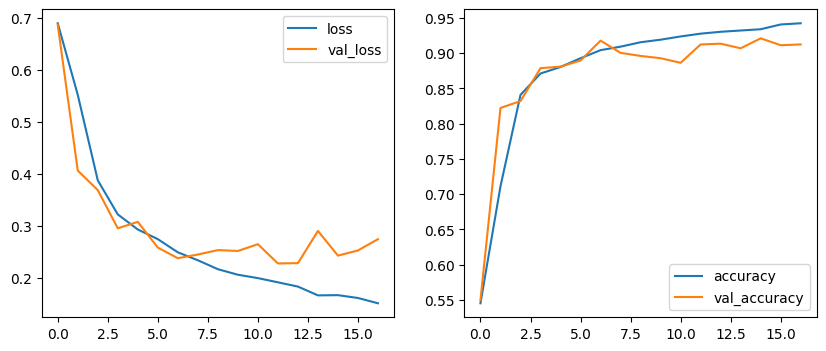

In [20]:
# Plotting the learning curves

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);


## Prediction

In [21]:
# Loading and transforming test data
X_test = pd.DataFrame(load_images_from_folder('../data/test-data/')).T
X_test.rename(columns={0: 'filename', 1: 'data'}, inplace=True)
testing_set_order = pd.read_csv('../Testing_set.csv')
testing_set_order.head()
testing_in_order_df = pd.merge(testing_set_order, X_test, on='filename')
X_test = list(testing_in_order_df['data'])
X_test_resized = downscaling(X_test)
X_test_resized_and_greyscaled = greyscaling(X_test_resized)
X_test_resized_and_greyscaled = normalise(X_test_resized_and_greyscaled)
X_test_resized_and_greyscaled.shape

(2305, 41, 41, 1)

In [22]:
# Predict
y_pred = model.predict(X_test_resized_and_greyscaled)

73/73 [==============================] - 0s 2ms/step


In [23]:
print(f'min value from prediction: {np.min(y_pred)}')
print(f'max value from prediction: {np.max(y_pred)}')

min value from prediction: 8.175863631942892e-12
max value from prediction: 1.0


In [24]:
y_pred

array([[0.9999381 ],
       [0.3957923 ],
       [0.973945  ],
       ...,
       [0.999985  ],
       [0.9999083 ],
       [0.99872315]], dtype=float32)

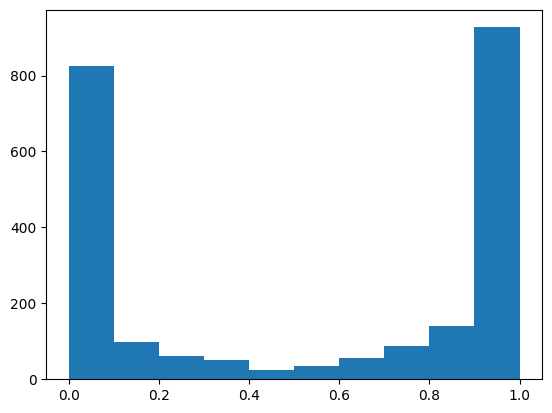

In [25]:
plt.hist(y_pred);

To get our predictions out, we need to map y_pred <= 0.5 to "female" and y_pred > 0.5 to "male".

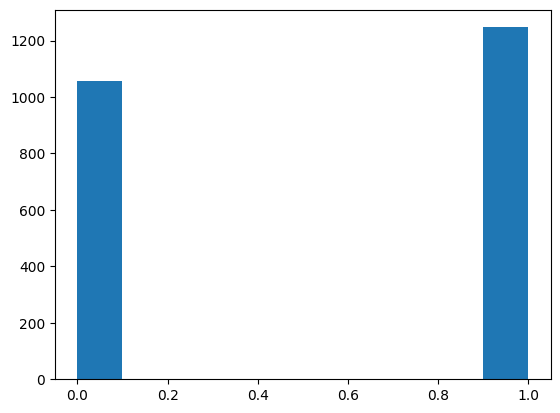

In [26]:
# Using boolean indexing to convert y_pred into integers

y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
plt.hist(y_pred);

In [27]:
# Making a pandas DataFrame for the predictions

predictions = pd.DataFrame(y_pred).rename(columns={0: "label"})
predictions['label'] = predictions['label'].map({0.0: 'female', 1.0: 'male'})
predictions

,label
0,male
1,female
2,male
3,male
4,male
...,...
2300,female
2301,female
2302,male
2303,male


In [28]:
# Writing the predictions into a csv for submission

predictions.to_csv('../predictions_for_testset.csv', index=False)
